In [1]:
import networkx as nx
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy
from collections import deque
import seaborn as sns
from matplotlib.pyplot import cm

In [2]:
lambdas = list(np.round(np.arange(0, 2, 0.1), 1)) + [2, 5, 10]
# lambdas = list(np.round(np.arange(0, 1, 0.1), 1)) + [1, 2, 5, 10]

lambdasToString = [str(l) for l in lambdas]
prefType = 'LinNorm'
input_file = f'./csDS549_{prefType}.pickle'
numOfUniqueProjects = 6 # 519 -> 7, 506 -> 14

## Input analysis

In [3]:
def project_term(x):
    # Requires definition of lambda_
    res = 0
    # project preference term
    for u in nodes:
        for p in projects:
            if (u, p) in c and (u, p) in x:
                res += c[(u, p)] * x[(u, p)]
    return res

def conflict_term(x):
    res = 0
    for e in edges:
        u, v = e
        inner_sum = 0
        for p in projects:
            if (u, p) in x and (v, p) in x:
                inner_sum += x[(u, p)] * x[(v, p)]
        res += 1 * (1 - inner_sum)
    return res
    
def f(x):
    # Requires definition of lambda_
    return lambda_ * project_term(x) + conflict_term(x) 

In [4]:
with open(input_file, 'rb') as file:
    projects = pickle.load(file)
    capacities = pickle.load(file)
    numOfProjects = len(capacities)
    c = pickle.load(file)
    w = pickle.load(file)
    edges = pickle.load(file)
    wE = sum([w[e] for e in w])
    assignment = pickle.load(file)
    representatives = pickle.load(file)
    
G = nx.Graph()
G.add_edges_from(edges)
nodes = list(G.nodes)
n = len(nodes)
G_c = nx.complement(G)
pos=nx.spring_layout(G_c, k=0.2, iterations=20)

In [5]:
len(projects)

6

number of (conflict) edges = 311
number of nodes = 26


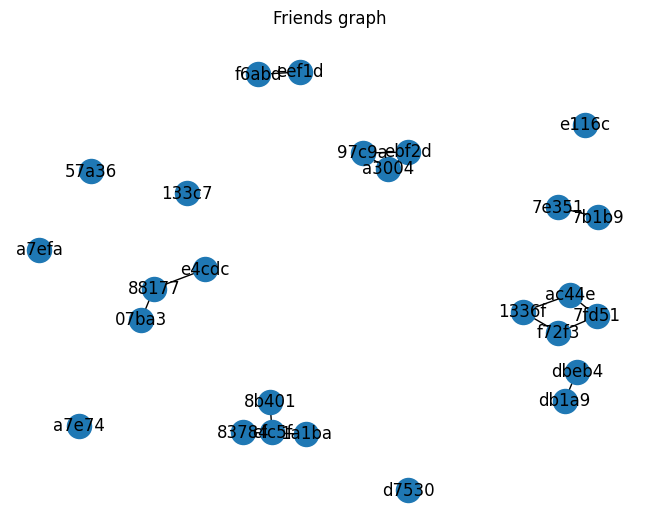

In [44]:
G_c = nx.complement(G)
    
print(f'number of (conflict) edges = {len(edges)}')
print(f'number of nodes = {len(G_c.nodes)}')
nx.draw(G_c, pos=nx.spring_layout(G_c, k=0.2, iterations=20), with_labels=True)
plt.title(f'Friends graph')
plt.savefig('./figs/friends_graph_549.png', bbox_inches='tight')
plt.show()

## Read the results

In [7]:
settings = dict()
results = dict()
times = dict()

for l in lambdasToString:
    results_file = f'results/csDS549_{l}.pickle'
    with open(results_file, 'rb') as file:
        settings[l] = pickle.load(file)
        edges = pickle.load(file)
        results[l] = pickle.load(file)
        times[l] = pickle.load(file)
        file.close()

In [8]:
obj_opt = dict()
obj_round12 = dict()
obj_round34 = dict()
obj_random = dict()
obj_greedy = dict()


x_round12 = dict()
x_round34 = dict()
x_opt = dict()
x_random = dict()
x_greedy = dict()

for i in range(len(lambdas)):
    l = lambdasToString[i]
    lambda_mul = lambdas[i]
    lambda_ = lambda_mul * sum(w.values()) / n

    res = results[l]
    
    x_opt[l] = res["quad_sol"]
    x_round12[l] = res["rounded_sol12"]
    x_round34[l] = res["rounded_sol34"]
    x_random[l] = res["random_sol"]
    x_greedy[l] = res["greedy_sol"]
    
    obj_opt[l] = f(x_opt[l])
    obj_round12[l] = f(x_round12[l])
    obj_round34[l] = f(x_round34[l])
    obj_random[l] = f(x_random[l])
    obj_greedy[l] = f(x_greedy[l])    

    print(f'\n======= lambda = {l} ==========')
    print(f'approx ratio (1/2 approx) = {obj_round12[l] / obj_opt[l]}')
    print(f'approx ratio (3/4 approx) = {obj_round34[l] / obj_opt[l]}')
    print(f'approx ratio (random) = {obj_random[l] / obj_opt[l]}')
    print(f'approx ratio (greedy) = {obj_greedy[l] / obj_opt[l]}')


======= lambda = 0.0 ==========
approx ratio (1/2 approx) = 0.9571428571428572
approx ratio (3/4 approx) = 0.9607142857142857
approx ratio (random) = 0.975
approx ratio (greedy) = 0.9892857142857143

======= lambda = 0.1 ==========
approx ratio (1/2 approx) = 0.9647505922335786
approx ratio (3/4 approx) = 0.9667030796146087
approx ratio (random) = 0.9517654001657416
approx ratio (greedy) = 0.979782443099537

======= lambda = 0.2 ==========
approx ratio (1/2 approx) = 0.962725282518539
approx ratio (3/4 approx) = 0.9693276598368867
approx ratio (random) = 0.9322071134545118
approx ratio (greedy) = 0.9747891710220001

======= lambda = 0.3 ==========
approx ratio (1/2 approx) = 0.9727437170869548
approx ratio (3/4 approx) = 0.9677505672817571
approx ratio (random) = 0.9145170612664298
approx ratio (greedy) = 0.9783362589373636

======= lambda = 0.4 ==========
approx ratio (1/2 approx) = 0.9695055601263302
approx ratio (3/4 approx) = 0.9658695825260755
approx ratio (random) = 0.8983319621

## Hyperparemeter ($\lambda$) tuning

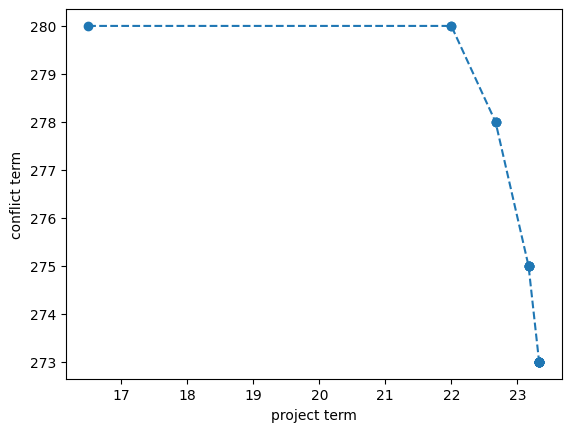

In [30]:
ys = np.array(np.round([conflict_term(x_opt[l]) for l in lambdasToString], 2))
xs = np.array(np.round([project_term(x_opt[l]) for l in lambdasToString], 2))
zs = xs + ys

plt.plot(xs, ys, "o--")
plt.ylabel('conflict term')
plt.xlabel('project term')
plt.show()

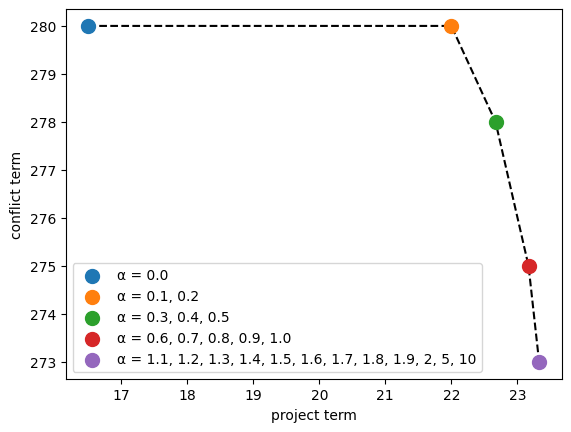

In [31]:
# Create a dictionary to group lambda values by (x, y) pairs
data_dict = {}
for i in range(len(lambdas)):
    xy_pair = (xs[i], ys[i])
    if xy_pair not in data_dict:
        data_dict[xy_pair] = []
    data_dict[xy_pair].append(lambdas[i])
    
# Create a scatter plot and label points with lambda values
for xy_pair, ls in data_dict.items():
    x, y = xy_pair
    label = 'α = ' + ', '.join([f"{l}" for l in ls])
    plt.scatter(x, y, label=label, s=100, zorder=2)  # s is marker size

plt.plot(xs, ys, linestyle='--', marker='', color='black', zorder=1)
plt.xlabel('project term')
plt.ylabel('conflict term')
plt.legend()
plt.savefig(f'./figs/hyperparameter_549.png', bbox_inches='tight')
plt.show()

In [11]:
ls

[1.2, 1.3, 1.4, 1.5, 1.6, 1.9]

In [12]:
ys

array([280.        , 280.        , 280.        , 278.        ,
       278.        , 278.        , 275.        , 275.        ,
       275.        , 275.        , 275.00000085, 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        ])

In [27]:
xs

array([16.5       , 22.        , 22.        , 22.66666667, 22.66666667,
       22.66666667, 23.16666667, 23.16666667, 23.16666667, 23.16666667,
       23.16666667, 23.33333333, 23.33333333, 23.33333333, 23.33333333,
       23.33333333, 23.33333333, 23.33333333, 23.33333333, 23.33333333,
       23.33333333, 23.33333333, 23.33333333])

### Reconstruct teams

In [37]:
def construct_teams(x):
    teams = dict()
    for p in projects:
        teams[p] = []

    for e in x:
        u, p = e
        if x[e] == 1:
            u, p = e
            teams[p].append(u)
            
    for p in projects:
        teams[p].sort()
        
    return teams
            
teams_opt = dict()
teams_round12 = dict()
teams_round34 = dict()
teams_random = dict()
teams_greedy = dict()
for l in lambdasToString:    
    teams_opt[l] = construct_teams(x_opt[l])
    teams_round12[l] = construct_teams(x_round12[l])
    teams_round34[l] = construct_teams(x_round34[l])

    teams_random[l] = construct_teams(x_random[l])
    teams_greedy[l] = construct_teams(x_greedy[l])

### Compare $\lambda \sum_v \sum_t c_{vt}x_{vt}$ and $w(E)$
If $\alpha = \lambda \sum_v \sum_t c_{vt}x_{vt} - w(E) \geq 0$, then we can apply the $3/4$-approximation algorithm.
Otherwise, the guarantees of the algorithm do not hold.

In [15]:
print(f'w(E) = {wE}')
for l, lstr in zip(lambdas, lambdasToString):
    lambda_ = l * wE / n
    projectsVal = lambda_ * project_term(x_round34[lstr])
    print(f'\n===== lambda = {l} ======')
    print(f'projects term value = {projectsVal}')
    print(f'a = {projectsVal - wE}')

w(E) = 311

===== lambda = 0.0 ======
projects term value = 0.0
a = -311.0

===== lambda = 0.1 ======
projects term value = 26.11602564102563
a = -284.88397435897434

===== lambda = 0.2 ======
projects term value = 53.428205128205114
a = -257.5717948717949

===== lambda = 0.3 ======
projects term value = 77.74999999999999
a = -233.25

===== lambda = 0.4 ======
projects term value = 105.26153846153846
a = -205.73846153846154

===== lambda = 0.5 ======
projects term value = 123.60256410256405
a = -187.39743589743597

===== lambda = 0.6 ======
projects term value = 150.7153846153846
a = -160.2846153846154

===== lambda = 0.7 ======
projects term value = 180.02115384615382
a = -130.97884615384618

===== lambda = 0.8 ======
projects term value = 205.7384615384615
a = -105.26153846153849

===== lambda = 0.9 ======
projects term value = 245.8096153846154
a = -65.1903846153846

===== lambda = 1.0 ======
projects term value = 259.1666666666667
a = -51.833333333333314

===== lambda = 1.1 ======


### Time (seconds) for each step

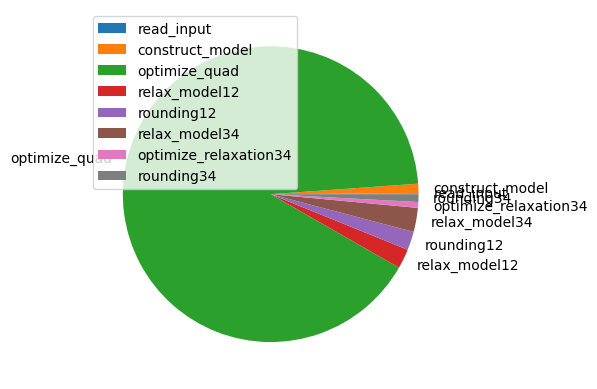

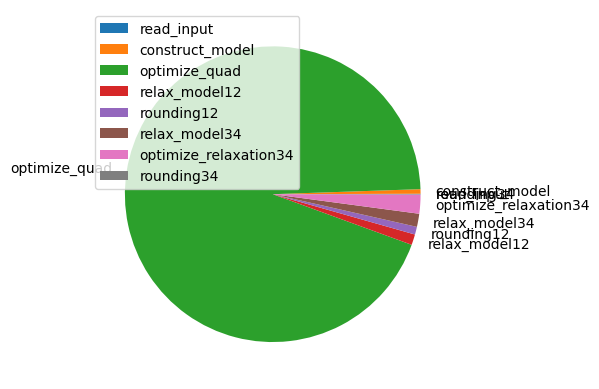

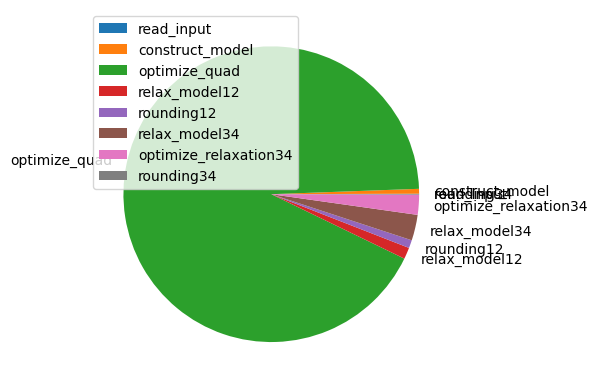

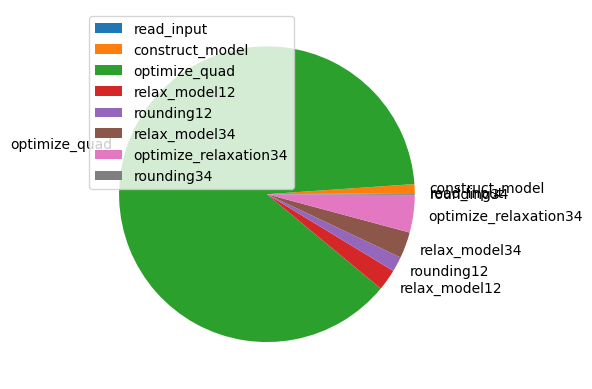

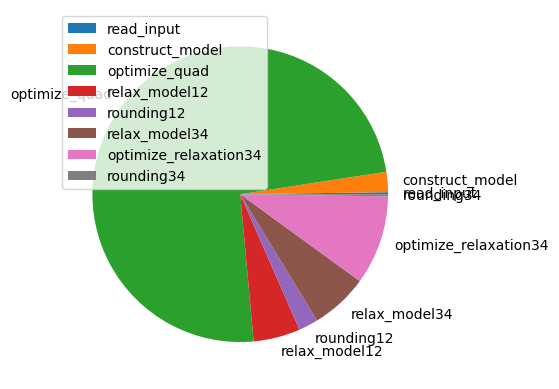

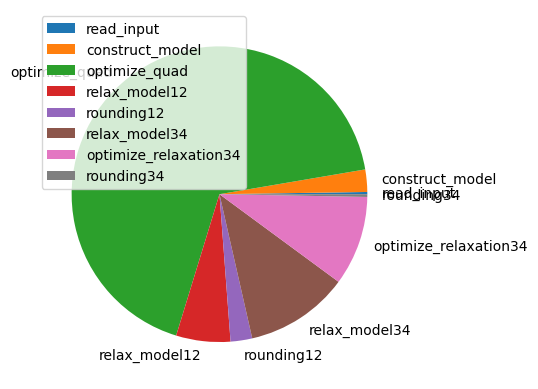

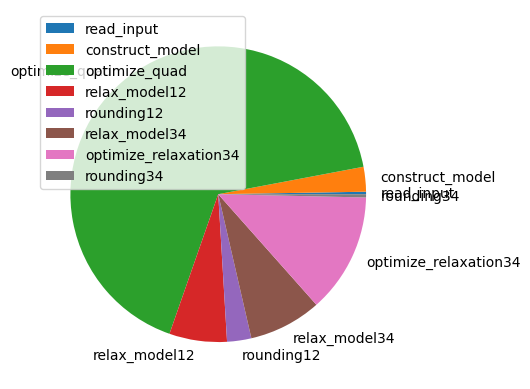

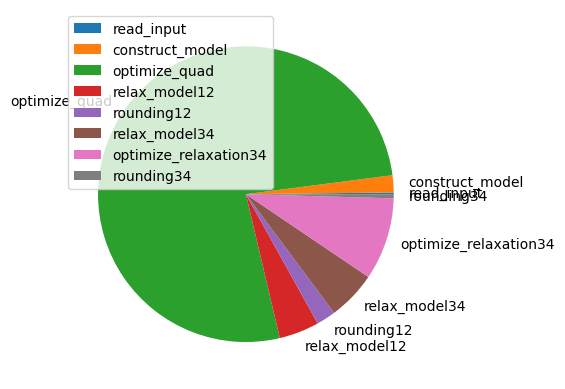

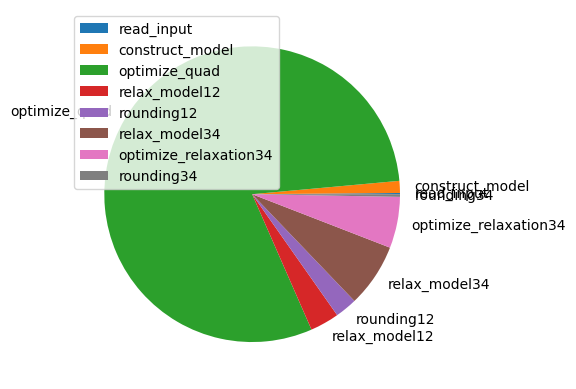

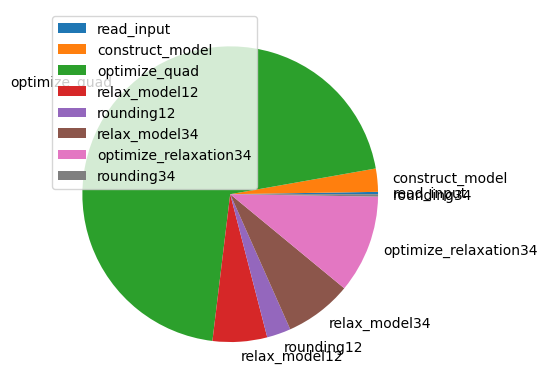

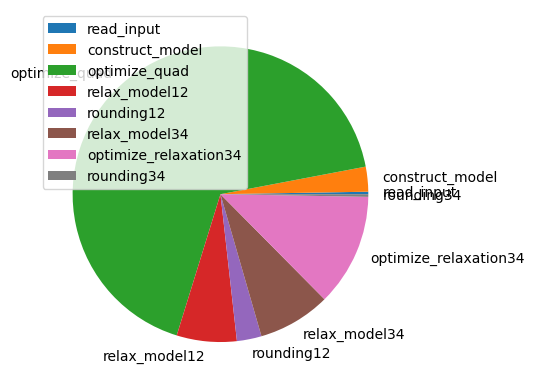

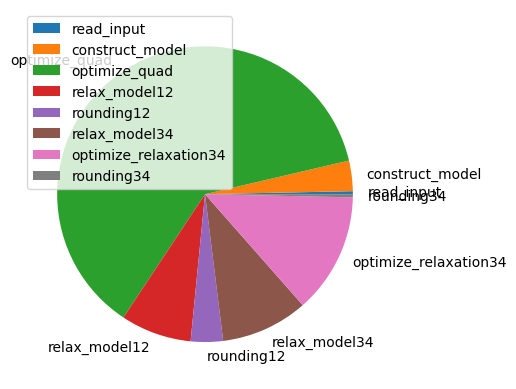

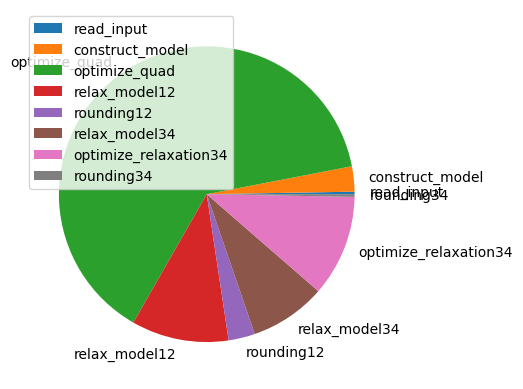

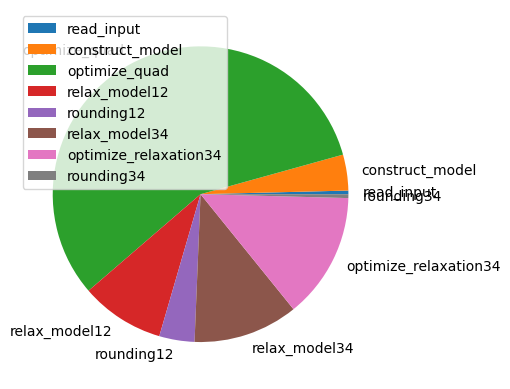

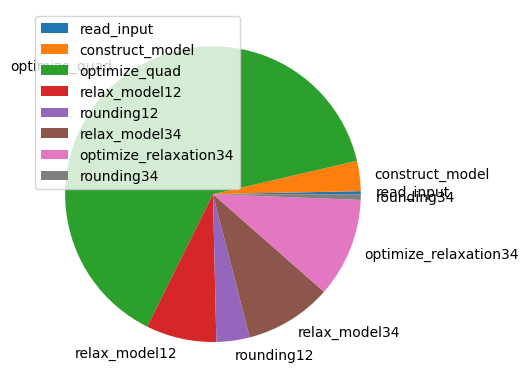

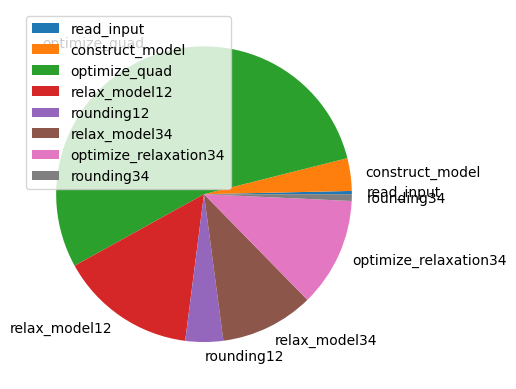

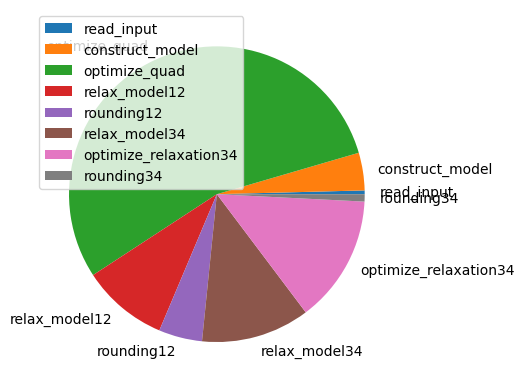

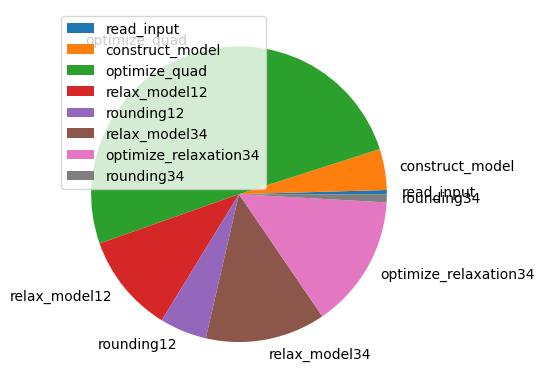

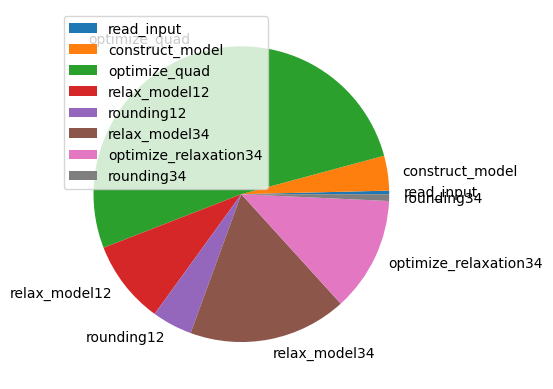

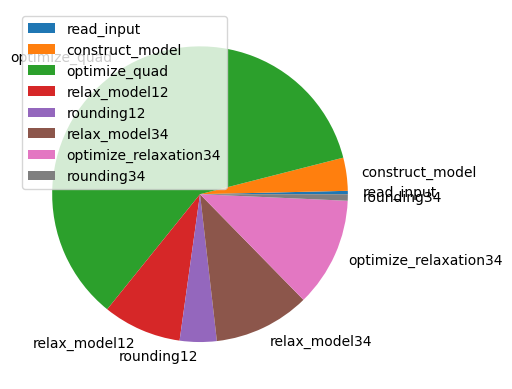

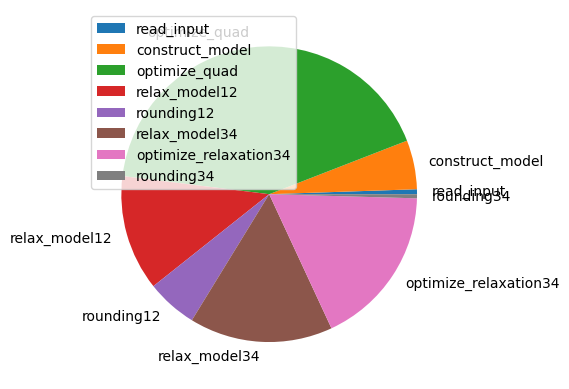

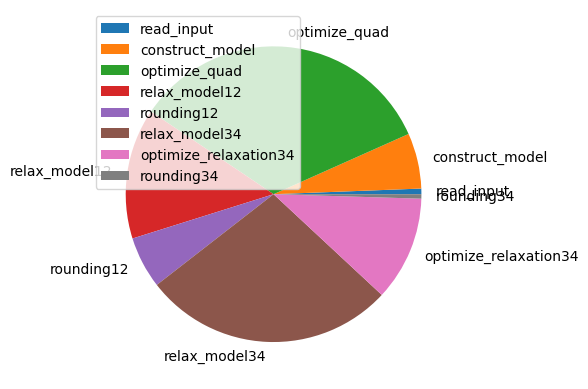

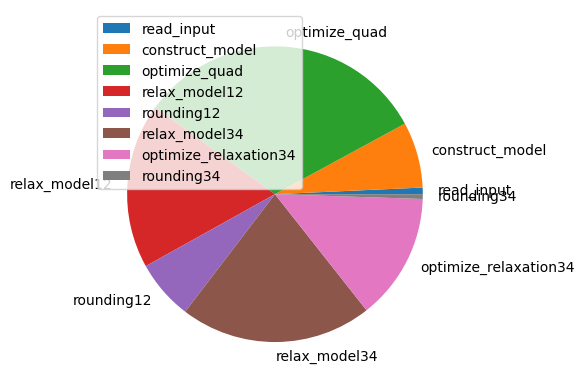

In [16]:
for l in lambdasToString:
    #del times["1.5"]["conflict_only"]
    plt.pie(times[l].values(), labels=times[l].keys(), normalize=True)
    plt.legend(loc='upper left')
    plt.show()

## Qualitative analysis

In [38]:
# Select a lambda
l = '1.5'

In [39]:
def min_friends(teams):
    minFriends = 2**30
    for team in teams.values():
        for u in team:
            friends = sum([1 for v in team if u != v and (u, v) not in w and (v, u) not in w])
            minFriends = min(friends, minFriends)
    if minFriends == 2**30:
        minFriends = 0
    return minFriends
            
def max_friends(teams):
    maxFriends = 0
    for team in teams.values():
        for u in team:
            friends = sum([1 for v in team if u != v and (u, v) not in w and (v, u) not in w])
            maxFriends = max(friends, maxFriends)
    return maxFriends

def avg_friends(teams):
    friends = 0
    for team in teams.values():
        friends += sum([1 for u in team for v in team if u != v and (u, v) not in w and (v, u) not in w])
    return friends / n

def reverse_pref(pref):
    if prefType == 'Lin':
        return numOfUniqueProjects - pref + 1
    elif prefType == 'LinNorm': 
        return numOfUniqueProjects - pref*numOfUniqueProjects + 1
    elif prefType == 'Exp':
        return 1 / pref
    return 'Error: No preference type defined'

def min_preference(teams):
    ans = 1
    for t in teams:
        team = teams[t]
        for u in team:
            ans = min(ans, reverse_pref(c[(u, t)]))      
    return ans
            
def max_preference(teams):
    ans = -1
    for t in teams:
        team = teams[t]
        for u in team:
            ans = max(ans, reverse_pref(c[(u, t)]))      
    return ans

def avg_preference(teams):
    pref = 0
    for t in teams:
        team = teams[t]
        pref += sum([reverse_pref(c[(u, t)]) for u in team])
    return pref / n

In [40]:
def group_keys_by_value(input_dict):
    grouped_dict = {}
    
    for key, value in input_dict.items():
        if value in grouped_dict:
            grouped_dict[value].append(key)
        else:
            grouped_dict[value] = [key]
    
    return grouped_dict
teams_manual = group_keys_by_value(assignment)

In [41]:
teams_optimal = teams_opt[l]
teams_pipage = teams_round12[l]
teams_randpipage = teams_round34[l]
teams_random = teams_random[l]
teams_greedy = teams_greedy[l]

### Average, min, max number of (in-team) friends for each student

In [42]:
print(f'(manual assignment) min number of friends {min_friends(teams_manual)}')
print(f'(manual assignment) max number of friends {max_friends(teams_manual)}')
print(f'(manual assignment) avg number of friends {avg_friends(teams_manual)}')

print(f'(optimal assignment) min number of friends {min_friends(teams_optimal)}')
print(f'(optimal assignment) max number of friends {max_friends(teams_optimal)}')
print(f'(optimal assignment) avg number of friends {avg_friends(teams_optimal)}')

print(f'(pipage assignment) min number of friends {min_friends(teams_pipage)}')
print(f'(pipage assignment) max number of friends {max_friends(teams_pipage)}')
print(f'(pipage assignment) avg number of friends {avg_friends(teams_pipage)}')

print(f'(rand pipage assignment) min number of friends {min_friends(teams_randpipage)}')
print(f'(rand pipage assignment) max number of friends {max_friends(teams_randpipage)}')
print(f'(rand pipage assignment) avg number of friends {avg_friends(teams_randpipage)}')

print(f'(random assignment) min number of friends {min_friends(teams_random)}')
print(f'(random assignment) max number of friends {max_friends(teams_random)}')
print(f'(random assignment) avg number of friends {avg_friends(teams_random)}')

print(f'(greedy assignment) min number of friends {min_friends(teams_greedy)}')
print(f'(greedy assignment) max number of friends {max_friends(teams_greedy)}')
print(f'(greedy assignment) avg number of friends {avg_friends(teams_greedy)}')

(manual assignment) min number of friends 0
(manual assignment) max number of friends 2
(manual assignment) avg number of friends 0.6923076923076923
(optimal assignment) min number of friends 0
(optimal assignment) max number of friends 2
(optimal assignment) avg number of friends 0.5384615384615384
(pipage assignment) min number of friends 0
(pipage assignment) max number of friends 1
(pipage assignment) avg number of friends 0.38461538461538464
(rand pipage assignment) min number of friends 0
(rand pipage assignment) max number of friends 1
(rand pipage assignment) avg number of friends 0.3076923076923077
(random assignment) min number of friends 0
(random assignment) max number of friends 1
(random assignment) avg number of friends 0.5384615384615384
(greedy assignment) min number of friends 0
(greedy assignment) max number of friends 2
(greedy assignment) avg number of friends 0.6923076923076923


### Average number of project preference for each student

In [43]:
print(f'(manual assignment) min preference {min_preference(teams_manual)}')
print(f'(manual assignment) max preference {max_preference(teams_manual)}')
print(f'(manual assignment) avg preference {avg_preference(teams_manual)}')

print(f'(optimal assignment) min preference {min_preference(teams_optimal)}')
print(f'(optimal assignment) max preference {max_preference(teams_optimal)}')
print(f'(optimal assignment) avg preference {avg_preference(teams_optimal)}')

print(f'(pipage assignment) min preference {min_preference(teams_pipage)}')
print(f'(pipage assignment) max preference {max_preference(teams_pipage)}')
print(f'(pipage assignment) avg preference {avg_preference(teams_pipage)}')

print(f'(rand pipage assignment) min preference {min_preference(teams_randpipage)}')
print(f'(rand pipage assignment) max preference {max_preference(teams_randpipage)}')
print(f'(rand pipage assignment) avg preference {avg_preference(teams_randpipage)}')

print(f'(random assignment) min preference {min_preference(teams_random)}')
print(f'(random assignment) max preference {max_preference(teams_random)}')
print(f'(random assignment) avg preference {avg_preference(teams_random)}')

print(f'(greedy assignment) min preference {min_preference(teams_greedy)}')
print(f'(greedy assignment) max preference {max_preference(teams_greedy)}')
print(f'(greedy assignment) avg preference {avg_preference(teams_greedy)}')

(manual assignment) min preference 1
(manual assignment) max preference 6.0
(manual assignment) avg preference 2.0384615384615383
(optimal assignment) min preference 1
(optimal assignment) max preference 6.0
(optimal assignment) avg preference 1.6153846153846154
(pipage assignment) min preference 1
(pipage assignment) max preference 6.0
(pipage assignment) avg preference 2.076923076923077
(rand pipage assignment) min preference 1
(rand pipage assignment) max preference 6.0
(rand pipage assignment) avg preference 2.0
(random assignment) min preference 1
(random assignment) max preference 6.0
(random assignment) avg preference 3.423076923076923
(greedy assignment) min preference 1
(greedy assignment) max preference 6.0
(greedy assignment) avg preference 2.076923076923077


### Friends graph colored based on team assignment

In [23]:
def draw_graph_with_teams(teams, title):
    activeTeams = [t for t in teams if teams[t]]
#     colors = sns.color_palette("tab10", len(activeTeams))
    colors = cm.rainbow(np.linspace(0, 1, len(activeTeams)))

    colors_dict = dict(zip(sorted(teams.keys()), colors))

    color_map = []
    for node in G:
        for team in teams:
            if node in teams[team]:
                color_map.append(colors_dict[team])
                break
                
    nx.draw(G_c, node_color=color_map, pos=pos, with_labels=True)
    for node in G:
        if representatives[node]:
            x, y = pos[node]
            plt.text(x + 0.09, y + 0.01, '*', fontsize=12, color='black', ha='center', va='center')
    plt.title(title)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color, markeredgecolor=color) for color, label in zip(colors, colors_dict.keys())]
    plt.legend(handles=legend_handles)
    plt.savefig(f'./figs/{title}_549.png', bbox_inches='tight')
    plt.show()

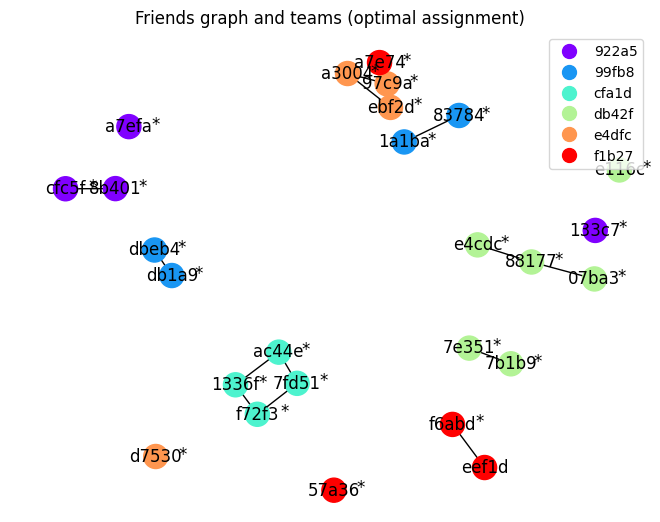

In [24]:
# draw_graph_with_teams(teams_manual, "Friends graph and teams (manual assignment)")
draw_graph_with_teams(teams_optimal, "Friends graph and teams (optimal assignment)")